In [1]:
import os
import fanc
import fanc.plotting as fancplot
from fanc.hic import kr_balancing

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np
import re

import matplotlib.colors as mcolors

# Define the custom colors
WtRdBl_vals = ['#FFFFFF', '#FF0000', '#000000']
diff_vals = ['#4356c7', '#FFFFFF', '#bc032b']
# Create a custom colormap using the defined colors
WtRdBl = mcolors.LinearSegmentedColormap.from_list('custom_cmap', WtRdBl_vals)
diff_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', diff_vals)

In [2]:
CHROM="chr19"
START=44370000
END=46320000

# Functions
Plotting functions adapted from Anania et al 2021

In [9]:
def plotTriangle(hic,coords,title,mask=False,cmap=WtRdBl, scale_to = 95, saveplt=True):
    chrom, start, end = re.split("[:-]",coords)
    size = int(end)-int(start)
    ext_start = int(start)-size//2
    ext_end = int(end) + size//2
    ext_coords = "{}:{}-{}".format(chrom,ext_start,ext_end)
    matrix = hic.matrix((ext_coords,ext_coords))
    nBins = len(matrix)
    startBin = nBins//4
    endBin = startBin*3
    
    # # calculate & format ticks for granges
    # tick_positions = range( int(start), int(end) + 1, 100000)
    # tick_labels = [f'{tick/1e6:.1f} Mb' for tick in tick_positions]

    if mask != False:
        matrix[(mask[0]+startBin):(mask[1]+startBin),:] = 0
        matrix[:,(mask[0]+startBin):(mask[1]+startBin)] = 0
    
    vmax = np.percentile(matrix.flatten(),scale_to)
    plot_title = title + ": vmax={}".format(vmax)
    plt.figure(figsize=(12,10))
    
    ## only plot upper triangle
    triangle = np.triu(matrix[:,:(nBins-1)], k = 1)
    sns.heatmap(triangle,vmax=vmax,square=True, cmap=cmap)
    
    plt.axline((startBin,startBin),(startBin+1,startBin-1))
    plt.axline((endBin,endBin),(endBin+1,endBin-1))
    plt.axline((1,1),(2,2))
    plt.axline((endBin,startBin),(endBin+1,startBin+1),color="r")
    plt.title(plot_title)
    
    if saveplt:
        filename = "_svg2/{}.svg".format(title)
        plt.savefig(filename,dpi=300,transparent=True)

In [8]:
def diff(fanc1,fanc2,coords,title,vrange=False,mask=False,norm=False, cmap=diff_cmap, saveplt=True):
    if not norm:
        matrix1 = fanc1.matrix((coords,coords),norm=False)
        matrix2 = fanc2.matrix((coords,coords),norm=False)
    else:
        matrix1 = fanc1.matrix((coords,coords))
        matrix2 = fanc2.matrix((coords,coords))
    factor = np.nanmean(matrix2)/np.nanmean(matrix1)
    matrix1 = matrix1*factor
    diff = matrix1-matrix2
    diag_idx = np.diag_indices_from(matrix2)
    diff[diag_idx] = 0
    diag_idx=diag_idx[0]
    nBins = len(matrix1)
    for offset in range(1,nBins):
        index1 = diag_idx[:-offset]
        index2 = diag_idx[offset:]
        diagMean = matrix1[index1,index2].mean()
        diff[index1,index2] = diff[index1,index2]/diagMean
        diff[index1,index2] = (diff[index1,index2]-diff[index1,index2].mean())/np.std(diff[index1,index2])
        diff[index2,index1] = diff[index1,index2]
    diff[(diff<2) & (diff>-2)] = 0
    if not vrange:
        vrange = int(max(abs(max(diff.flatten())),
                         abs(min(diff.flatten()))))
        print(vrange)
    startBin = nBins//4
    endBin = startBin*3
    if mask != False:
        diff[(mask[0]+startBin):(mask[1]+startBin),:] = 0
        diff[:,(mask[0]+startBin):(mask[1]+startBin)] = 0
    plt.figure(figsize=(12,10))
    
    sns.heatmap(diff,cmap=cmap,vmax=vrange,vmin=-vrange,square=True)
    plt.axline((startBin,startBin),(startBin+1,startBin-1),color="black")
    plt.axline((endBin,endBin),(endBin+1,endBin-1),color="black")
    plt.axline((1,1),(2,2),color="black")
    plt.axline((endBin,startBin),(endBin+1,startBin+1),color="black")
    plt.title(title)
    
    if saveplt:
        filename = "_svg2/{}.svg".format(title)
        plt.savefig(filename,dpi=300,transparent=True)

In [25]:
def getExtCoords(coords):
    chrom, start, end = re.split("[:-]",coords)
    size = int(end)-int(start)
    ext_start = int(start)-size//2
    ext_end = int(end) + size//2
    ext_coords = "{}:{}-{}".format(chrom,ext_start,ext_end)
    return ext_coords

# Downsample het & WT accordingly

In [ ]:
%%bash

## downsample het mutant to half
## downsample WT to = half het mutant

HERE=$(realpath .)
Dac="$HERE"/Dac_mm10/_hic
LTR="$HERE"/5LTRLacZ_mm10/_hic

# LTR

[[ -f "$LTR"/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds50.hic ]] || fanc hic \
--deepcopy --downsample 0.5 \
"$LTR"/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30.hic@5kb "$LTR"/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds50.hic

[[ -f "$LTR"/FLHL_WT_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds5LTR.hic ]] || fanc hic \
--deepcopy --downsample "$LTR"/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30_5kb.ds50.hic \
"$LTR"/FLHL_WT_merged_5LTRLacZ_mm10_enriched_MAPQ30.hic@5kb "$LTR"/FLHL_WT_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds5LTR.hic


# DacBl6

[[ -f "$Dac"/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.5kb.ds50.hic ]] || fanc hic \
--deepcopy --downsample 0.5 \
"$Dac"/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.hic@5kb "$Dac"/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.5kb.ds50.hic


[[ -f "$Dac"/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.5kb.dsDacBl6.hic ]] || fanc hic \
--deepcopy --downsample "$Dac"/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30_5kb.ds50.hic \
"$Dac"/FLHL_WT_merged_Dac_mm10_enriched_MAPQ30.hic@5kb "$Dac"/FLHL_WT_merged_Dac_mm10_enriched_MAPQ30.5kb.dsDacBl6.hic


# KR normalizing after downsampling

In [ ]:
# After downsampling, binned matrices need to be normalized separately

hic_wt_dac_scaled = fanc.load('Dac_mm10/_hic/FLHL_WT_merged_Dac_mm10_enriched_MAPQ30_5kb.dsDacBl6.hic', mode ='a')
hic_dac6_scaled = fanc.load('Dac_mm10/_hic/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.5kb.ds50.hic', mode ='a')
hic_wt_5ltr_scaled = fanc.load('5LTRLacZ_mm10/_hic/FLHL_WT_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds5LTR.hic', mode ='a')
hic_5tlr_scaled = fanc.load('5LTRLacZ_mm10/_hic/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds50.hic', mode ='a')

# Normalization is done in place and written to file 
to_norm = [hic_wt_5ltr_scaled, hic_5tlr_scaled, hic_wt_dac_scaled, hic_dac6_scaled]
for myhic in to_norm:
    kr_balancing(myhic, whole_matrix = False, restore_coverage=True)
    myhic.close()

# Plot HiC

In [5]:
coords = 'chr19:45100000-45900000'

In [6]:
hic_dac129 = fanc.load('Dac_mm10/_hic/FLHL_Dac129_merged_Dac_mm10_enriched_MAPQ30.hic@5kb@KR')
hic_wt = fanc.load('mm10/_hic/FLHL_WT_merged_mm10_enriched_MAPQ30.hic@5kb@KR')
hic_dac129h = fanc.load('Dac_mm10/_hic/heart_Dac129_merged_Dac_mm10_enriched_MAPQ30.hic@5kb@KR')

## load scaled het mutant for LTR
hic_5ltr_scaled =fanc.load('5LTRLacZ_mm10/_hic/FLHL_5LTR_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds50.hic')
hic_dac6_scaled = fanc.load('Dac_mm10/_hic/FLHL_DacBl6_merged_Dac_mm10_enriched_MAPQ30.5kb.ds50.hic')

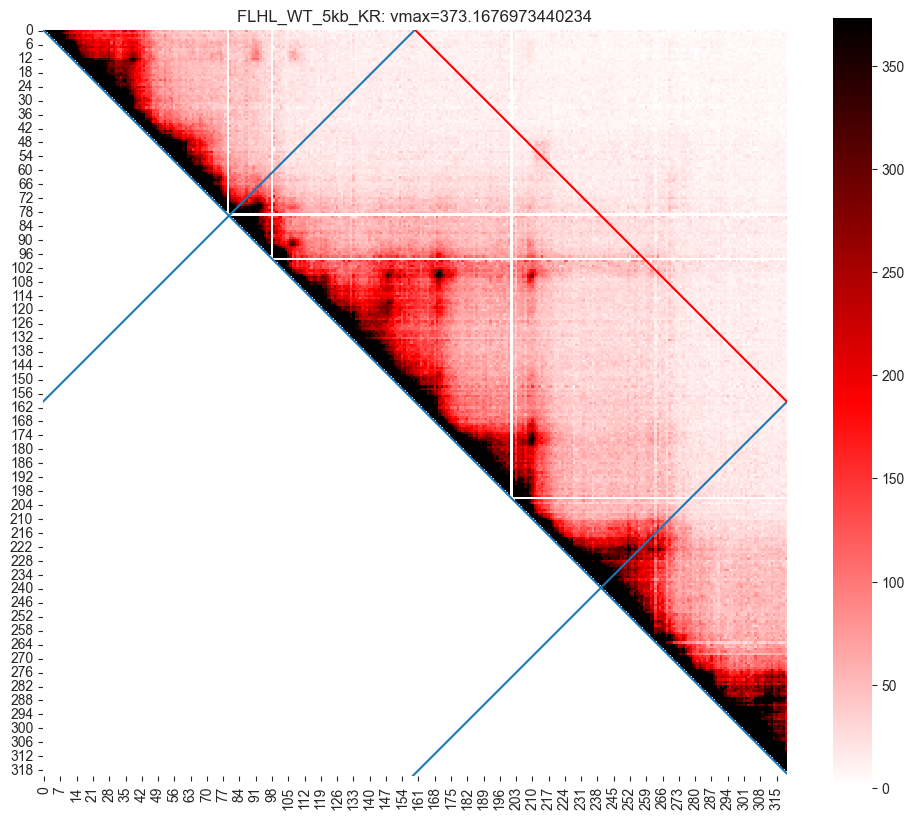

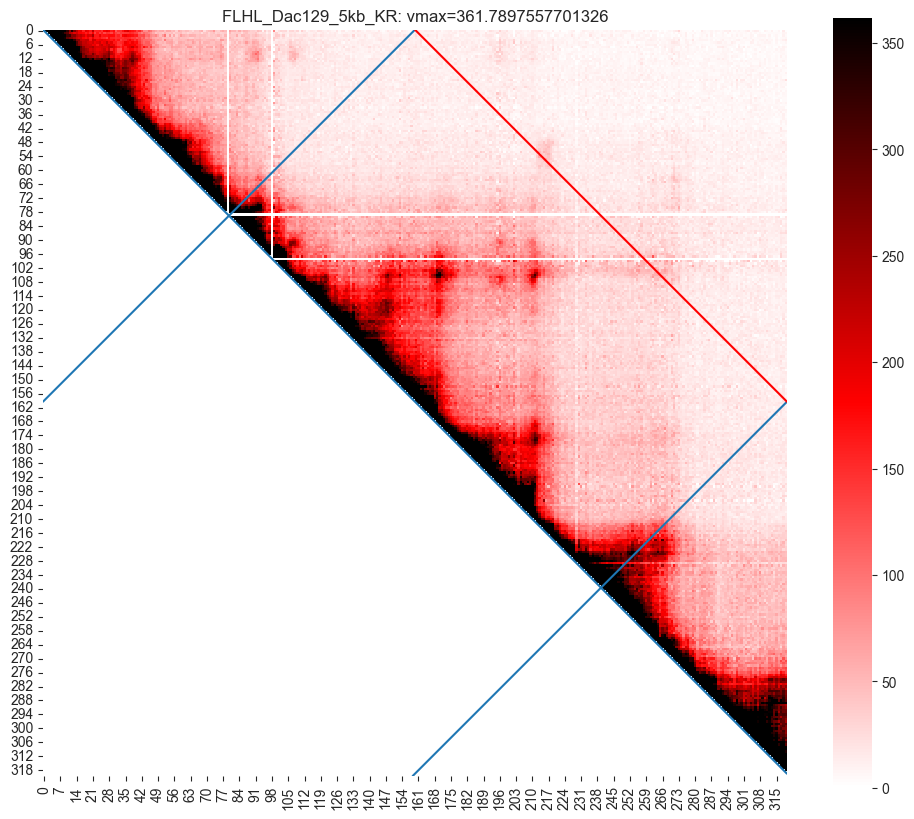

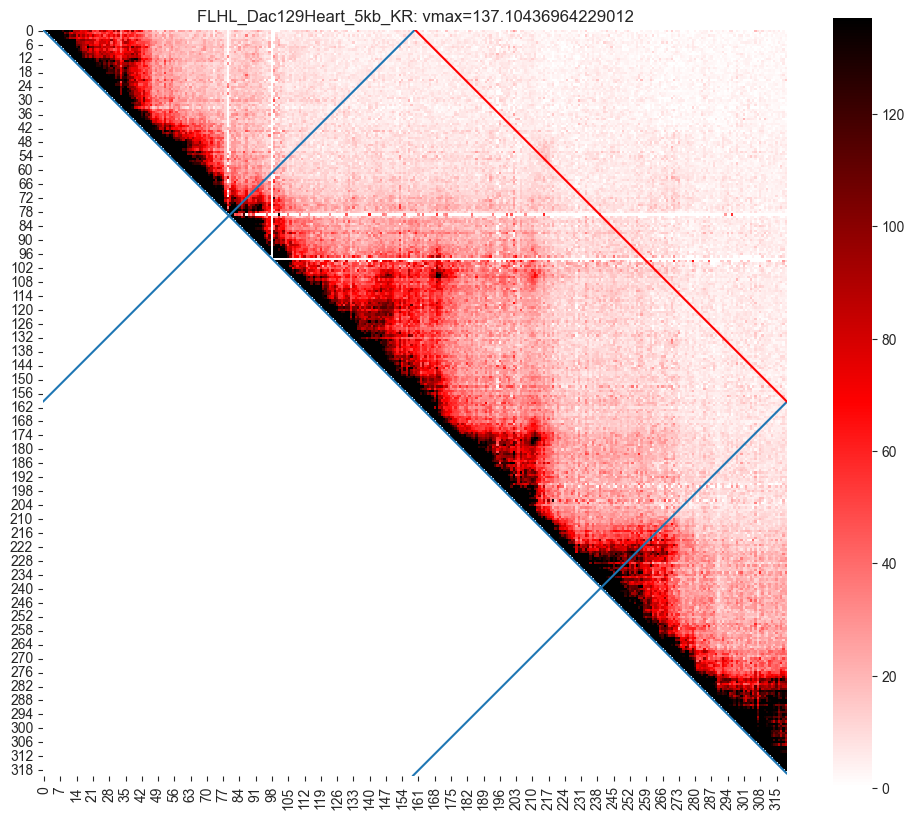

In [21]:
plotTriangle(hic_wt, coords, 'FLHL_WT_5kb_KR')
plotTriangle(hic_dac129, coords, 'FLHL_Dac129_5kb_KR')
plotTriangle(hic_dac129h, coords, 'FLHL_Dac129Heart_5kb_KR')

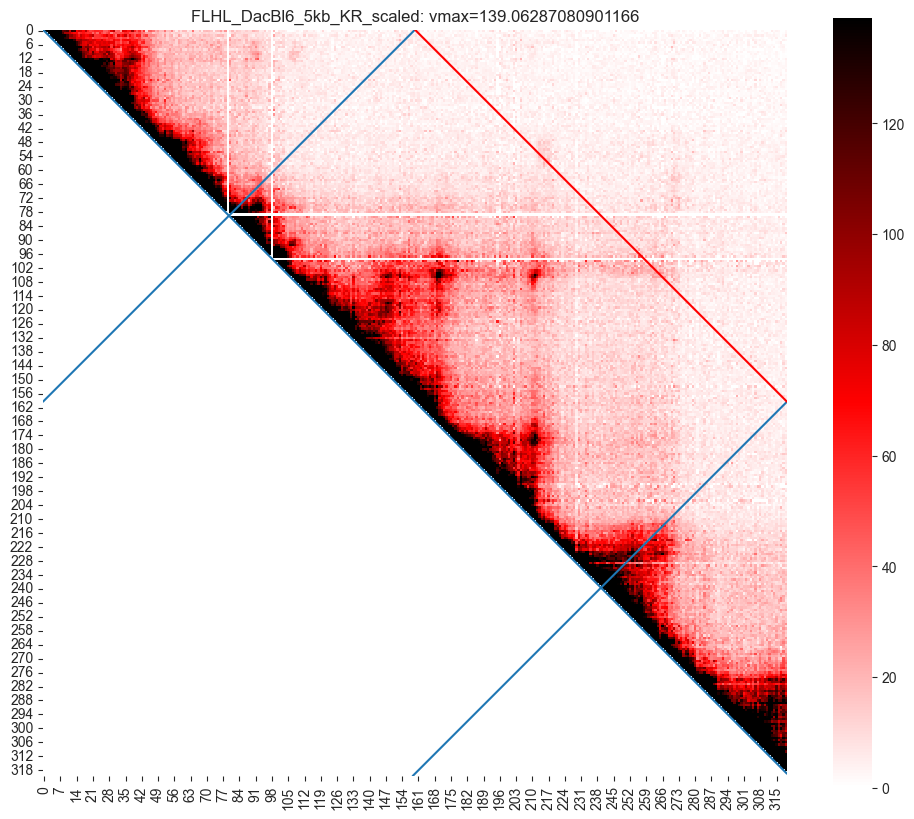

In [17]:
plotTriangle(hic_dac6_scaled, coords, 'FLHL_DacBl6_5kb_KR_scaled')

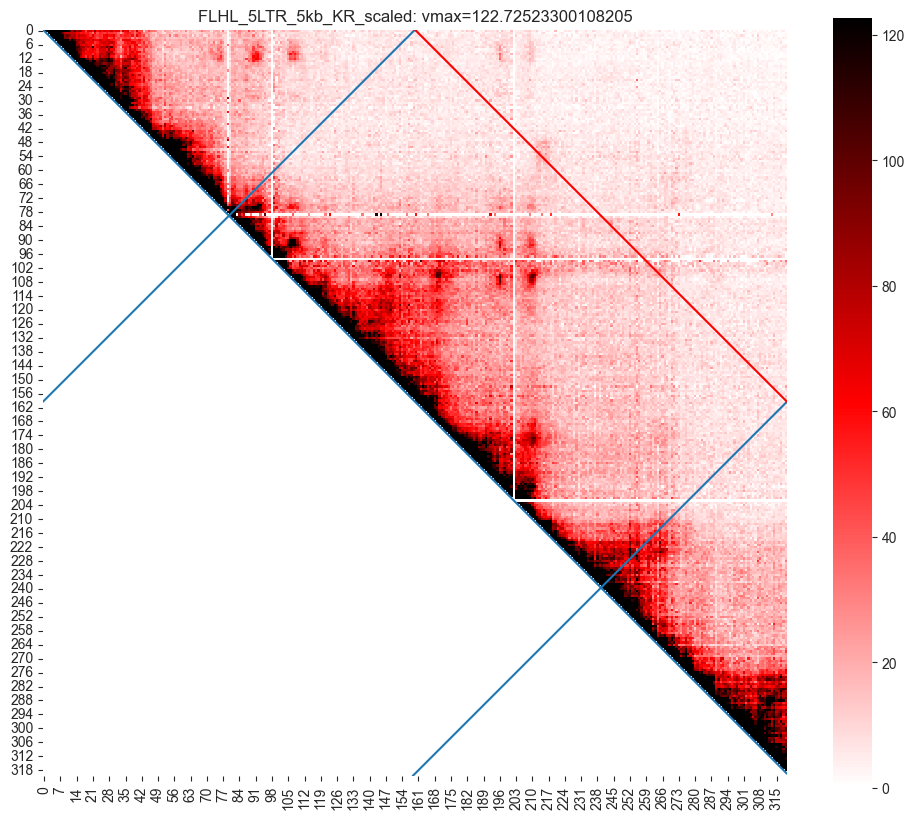

In [18]:
plotTriangle(hic_5ltr_scaled, coords, 'FLHL_5LTR_5kb_KR_scaled', scale_to = 96)

# Plot substraction map

In [23]:
## load WT maps on Dac custom genome

hic_wt_dac = fanc.load('Dac_mm10/_hic/FLHL_WT_merged_Dac_mm10_enriched_MAPQ30.hic@5kb@KR')

## load WT maps on custom genome & scaled by het mutants

hic_wt_dac_scaled = fanc.load('Dac_mm10/_hic/FLHL_WT_merged_Dac_mm10_enriched_MAPQ30.5kb.dsDacBl6.hic')
hic_wt_5ltr_scaled = fanc.load('5LTRLacZ_mm10/_hic/FLHL_WT_merged_5LTRLacZ_mm10_enriched_MAPQ30.5kb.ds5LTR.hic')

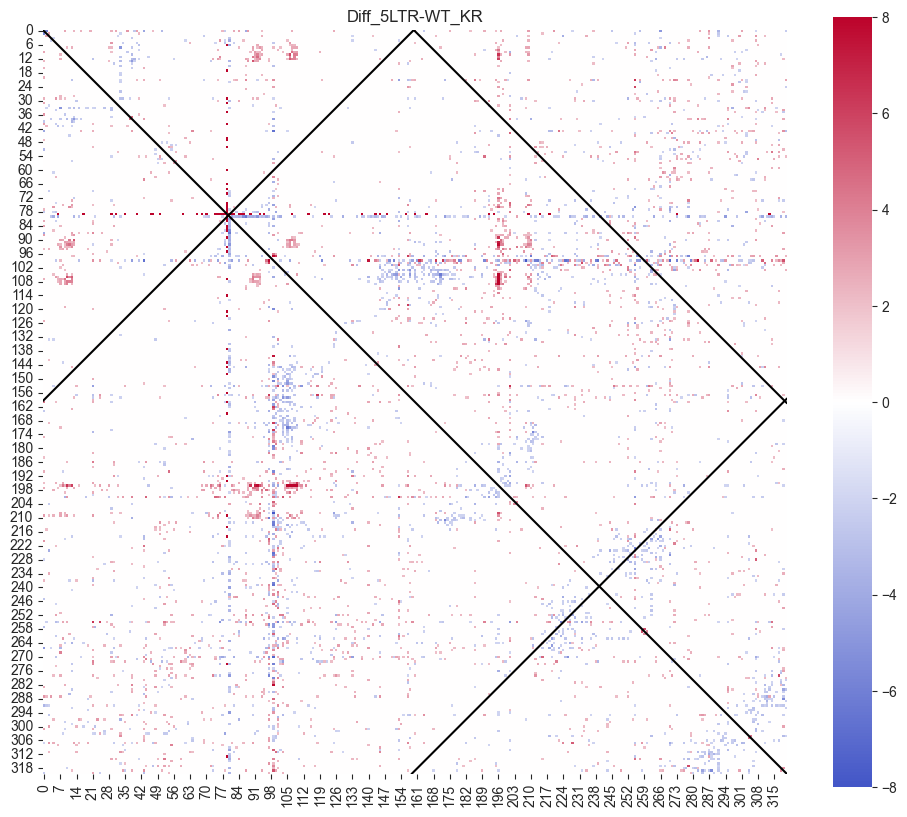

In [27]:
diff(hic_5ltr_scaled, hic_wt_5ltr_scaled, coords=getExtCoords(coords), title='Diff_5LTR-WT_KR', norm=True, vrange=8)

/project/4c_gene_reg/mikie/juliane_dac/fanc_venv/lib/python3.9/site-packages/fanc/compatibility/juicer.py:791: UserWarning: Cannot find normalisation vector for chromosome: chr1, normalisation: KR, resolution: 5000, unit: BP. This could indicate that KR normalisation did not work for this chromosome. Will return NaN instead.
  warnings.warn("Cannot find normalisation vector for "
/project/4c_gene_reg/mikie/juliane_dac/fanc_venv/lib/python3.9/site-packages/fanc/compatibility/juicer.py:791: UserWarning: Cannot find normalisation vector for chromosome: chr2, normalisation: KR, resolution: 5000, unit: BP. This could indicate that KR normalisation did not work for this chromosome. Will return NaN instead.
  warnings.warn("Cannot find normalisation vector for "
/project/4c_gene_reg/mikie/juliane_dac/fanc_venv/lib/python3.9/site-packages/fanc/compatibility/juicer.py:791: UserWarning: Cannot find normalisation vector for chromosome: chr3, normalisation: KR, resolution: 5000, unit: BP. This cou

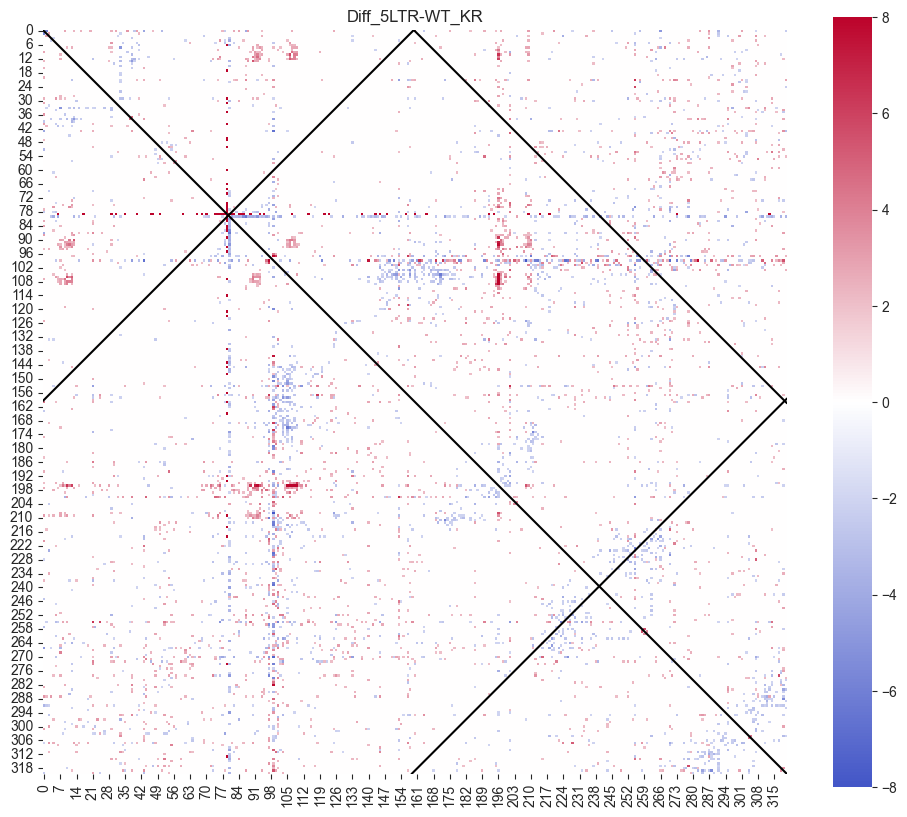

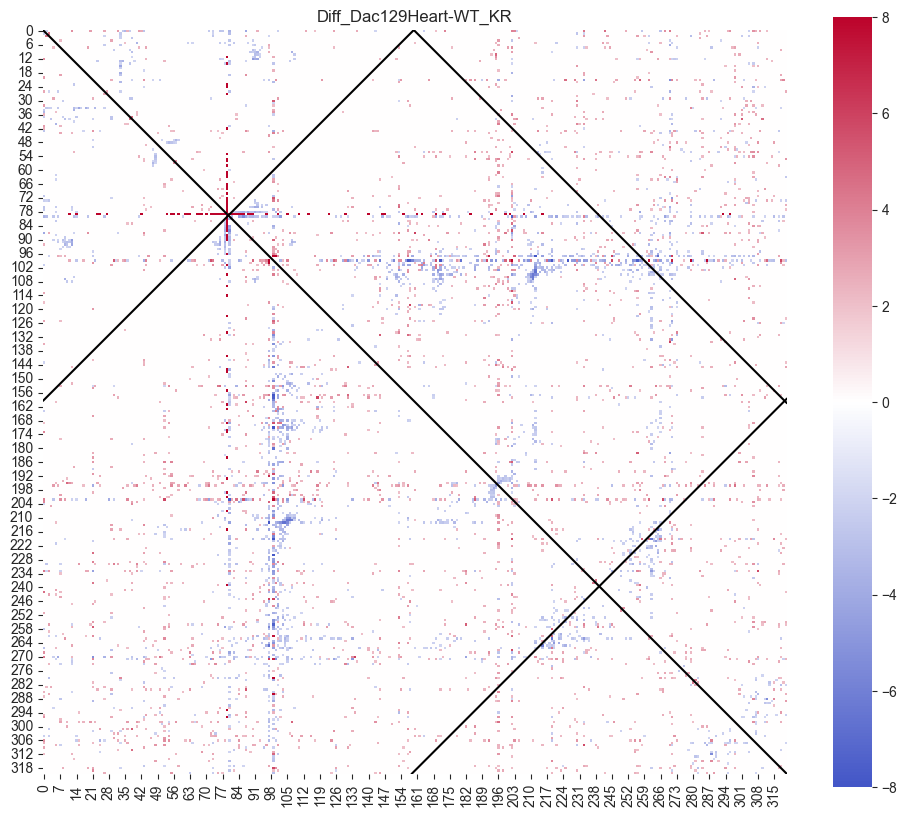

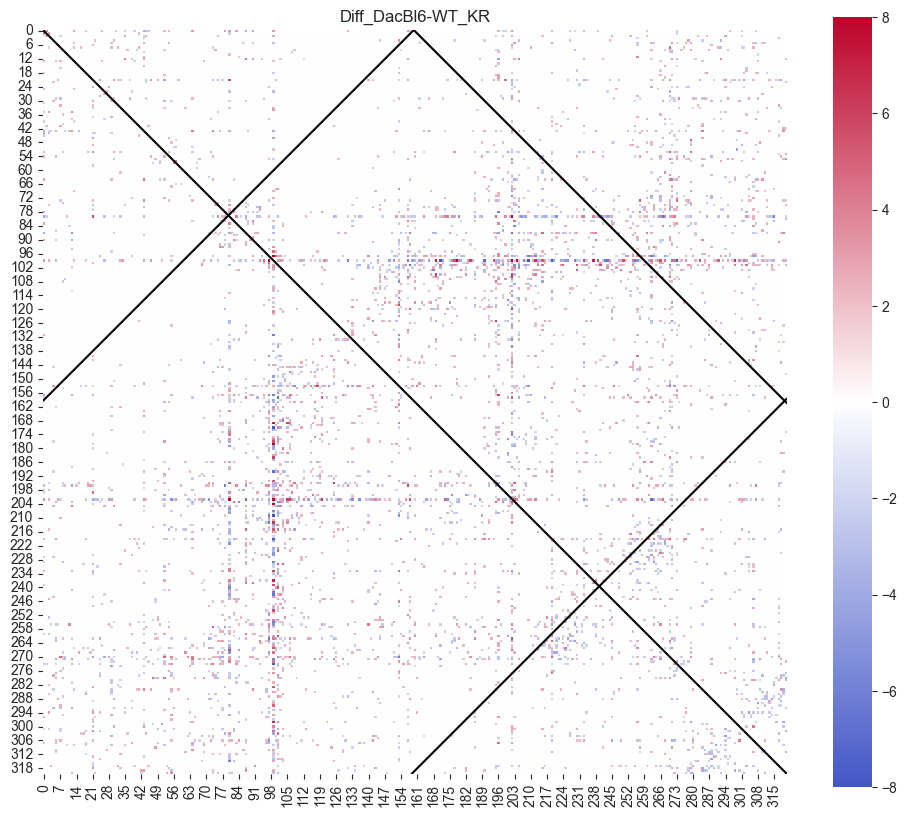

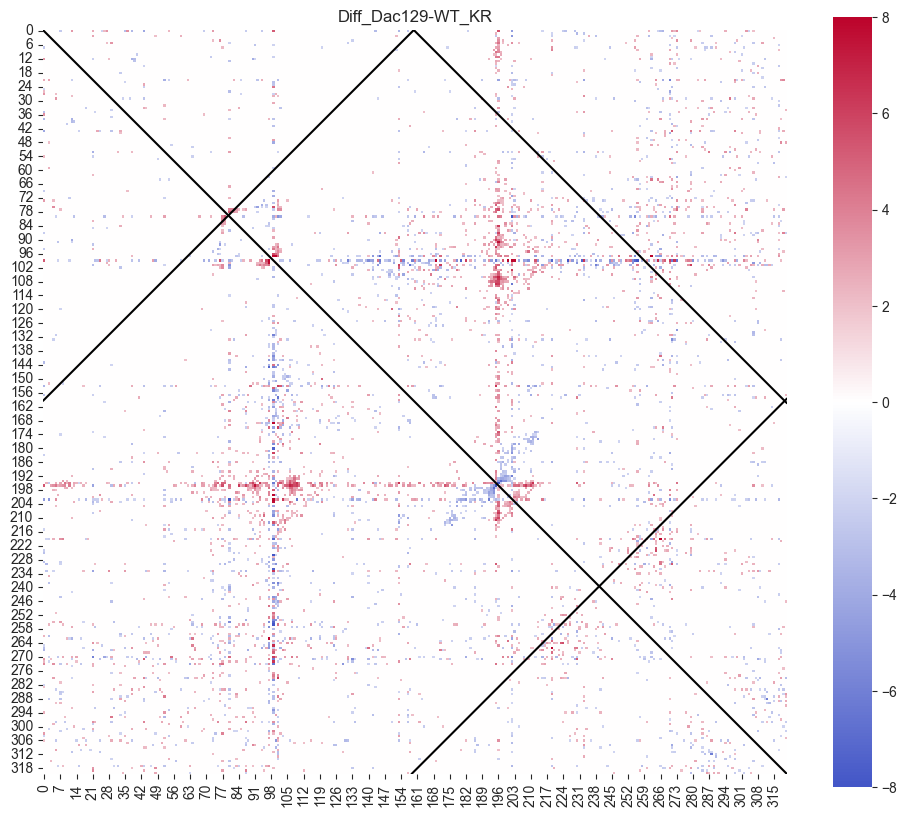

In [31]:
diff(hic_5ltr_scaled, hic_wt_5ltr_scaled, coords=getExtCoords(coords), title='Diff_5LTR-WT_KR', norm=True, vrange=8)

diff(hic_dac129h, hic_wt_dac, coords=getExtCoords(coords), title='Diff_Dac129Heart-WT_KR', norm=True, vrange=8)

diff(hic_dac6_scaled, hic_wt_dac_scaled, coords=getExtCoords(coords), title='Diff_DacBl6-WT_KR', norm=True, vrange=8)

diff(hic_dac129, hic_wt_dac, coords=getExtCoords(coords), title='Diff_Dac129-WT_KR', norm=True, vrange=8)